<a href="https://colab.research.google.com/github/Jundula/ML/blob/main/ARISOY_ABD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Group Project**

## **Step 1: Load Stock Data**

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression


stock_data_path = "data.csv"  # File uploaded to Colab
stock_data = pd.read_csv(stock_data_path)

# Convert date column to datetime format
stock_data['date'] = pd.to_datetime(stock_data['date'])

# Filter data: Prices > $1, Exchange codes 1, 2, or 3, Share codes 10 or 11
filtered_data = stock_data[
    (stock_data['PRC'].abs() > 1) &
    (stock_data['EXCHCD'].isin([1, 2, 3])) &
    (stock_data['SHRCD'].isin([10, 11]))
]

# Calculate market equity (ME)
filtered_data['ME'] = filtered_data['PRC'].abs() * filtered_data['SHROUT']

# Sort by PERMNO and date
filtered_data = filtered_data.sort_values(by=['PERMNO', 'date'])

In [40]:
filtered_data

,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT,ME
0,10001,1986-09-30,11,3,6.3750,-0.003077,991,6317.6250
1,10001,1986-10-31,11,3,6.6250,0.039216,991,6565.3750
2,10001,1986-11-28,11,3,7.0000,0.056604,991,6937.0000
3,10001,1986-12-31,11,3,7.0000,0.015000,991,6937.0000
4,10001,1987-01-30,11,3,6.7500,-0.035714,991,6689.2500
...,...,...,...,...,...,...,...,...
1048570,55466,1998-06-30,11,1,28.1250,-0.048626,10499,295284.3750
1048571,55466,1998-07-31,11,1,25.0000,-0.111111,10499,262475.0000
1048572,55466,1998-08-31,11,1,22.0000,-0.117500,10525,231550.0000
1048573,55466,1998-09-30,11,1,16.0625,-0.269886,10525,169057.8125


##**Step 2: Load Fama-French Factors**

In [2]:
ff_factors_path = "F-F_Research_Data_Factors.csv"  # File uploaded to Colab

# Skip the first 3 rows (descriptive text) and use row 4 as the header
ff_factors = pd.read_csv('https://raw.githubusercontent.com/Jundula/ML/refs/heads/main/F-F_Research_Data_Factors.csv', skiprows=3)

# Assign a label to the first column (date column)
ff_factors.columns = ['date'] + list(ff_factors.columns[1:])

# Drop rows where the 'date' column is NaN
ff_factors = ff_factors.dropna(subset=['date'])

# Filter out rows where the 'date' column does not match the YYYYMM format
ff_factors = ff_factors[ff_factors['date'].str.isdigit() & (ff_factors['date'].str.len() == 6)]

# Convert date column to datetime format
ff_factors['date'] = pd.to_datetime(ff_factors['date'], format='%Y%m')

# Rename columns for consistency
ff_factors.rename(columns={'Mkt-RF': 'mkt_excess_return'}, inplace=True)

# Ensure the dates align with the stock data
ff_factors = ff_factors.set_index('date').resample('ME').last().reset_index()

In [3]:
ff_factors

,date,mkt_excess_return,SMB,HML,RF
0,1926-07-31,2.96,-2.56,-2.43,0.22
1,1926-08-31,2.64,-1.17,3.82,0.25
2,1926-09-30,0.36,-1.40,0.13,0.23
3,1926-10-31,-3.24,-0.09,0.70,0.32
4,1926-11-30,2.53,-0.10,-0.51,0.31
...,...,...,...,...,...
1176,2024-07-31,1.24,6.80,5.74,0.45
1177,2024-08-31,1.61,-3.55,-1.13,0.48
1178,2024-09-30,1.74,-0.17,-2.59,0.40
1179,2024-10-31,-0.97,-1.01,0.89,0.39


##**Step 3: Load q-Factor Data**

In [5]:
q_factors_path = "q5_factors_monthly_2023.csv"  # File uploaded to Colab
q_factors = pd.read_csv('https://raw.githubusercontent.com/Jundula/ML/refs/heads/main/q5_factors_monthly_2023.csv')

# Combine year and month into a single date column
q_factors['date'] = pd.to_datetime(q_factors['year'].astype(str) + '-' + q_factors['month'].astype(str) + '-01')

# Rename columns for consistency (Replace 'R_ME' with your assigned factor)
q_factors.rename(columns={'R_MKT': 'mkt_excess_return', 'R_ME': 'allocated_factor'}, inplace=True)

# Drop unnecessary columns (year and month), but keep 'date', 'mkt_excess_return', and 'allocated_factor'
q_factors = q_factors[['date', 'mkt_excess_return', 'allocated_factor']]

# Ensure the dates align with the stock data
q_factors = q_factors.set_index('date').resample('ME').last().reset_index()

In [6]:
q_factors

,date,mkt_excess_return,allocated_factor
0,1967-01-31,8.1852,6.8122
1,1967-02-28,0.7557,1.6235
2,1967-03-31,4.0169,1.9836
3,1967-04-30,3.8786,-0.6700
4,1967-05-31,-4.2807,2.7366
...,...,...,...
679,2023-08-31,-2.3886,-2.3035
680,2023-09-30,-5.2404,-0.1586
681,2023-10-31,-3.1794,-2.6272
682,2023-11-30,8.8694,-0.7873


##**Step 4: Merge Stock Data with Factors**

In [7]:
merged_data = pd.merge(filtered_data, ff_factors, on='date', how='inner')
merged_data = pd.merge(merged_data, q_factors, on='date', how='inner')

# Resolve duplicate columns if necessary
if 'mkt_excess_return_x' in merged_data.columns and 'mkt_excess_return_y' in merged_data.columns:
    merged_data['mkt_excess_return'] = merged_data['mkt_excess_return_x']
    merged_data.drop(columns=['mkt_excess_return_x', 'mkt_excess_return_y'], inplace=True)

# Debug: Print columns after merging
print("Merged Data Columns:", merged_data.columns)

# Ensure RET and RF columns are numeric
merged_data['RET'] = pd.to_numeric(merged_data['RET'], errors='coerce')
merged_data['RF'] = pd.to_numeric(merged_data['RF'], errors='coerce')

# Calculate excess returns for each stock
merged_data['excess_return'] = merged_data['RET'] - merged_data['RF']

Merged Data Columns: Index(['PERMNO', 'date', 'SHRCD', 'EXCHCD', 'PRC', 'RET', 'SHROUT', 'ME',
       'SMB', 'HML', 'RF', 'allocated_factor', 'mkt_excess_return'],
      dtype='object')


##**Step 5: Create a Smaller Subset for Testing**

In [23]:
# Limit the date range to a shorter period (e.g., 1973–1983)
subset_data = merged_data

# Randomly select a subset of PERMNOs (e.g., 100 stocks)
unique_permnos = subset_data['PERMNO'].unique()
sample_permnos = np.random.choice(unique_permnos, size=100, replace=False)  # Randomly select 100 PERMNOs
subset_data = subset_data[subset_data['PERMNO'].isin(sample_permnos)]

# Verify the subset
print(f"Subset Data Shape: {subset_data.shape}")
print(f"Unique PERMNOs in Subset: {len(subset_data['PERMNO'].unique())}")

Subset Data Shape: (7026, 14)
Unique PERMNOs in Subset: 100


##**Step 6: Rolling Regression Function (Using TensorFlow for GPU Acceleration)**

In [24]:
def rolling_regression_tensorflow(data, window=60):  # Use full window size for testing
    betas_mkt = []
    betas_allocated = []

    for i in range(window, len(data)):
        # Extract the rolling window
        window_data = data.iloc[i-window:i]

        # Drop rows with NaN values in any of the required columns
        window_data = window_data.dropna(subset=['mkt_excess_return', 'allocated_factor', 'excess_return'])

        # Skip if there are fewer than 2 observations (minimum required for regression)
        if len(window_data) < 2:
            betas_mkt.append(np.nan)
            betas_allocated.append(np.nan)
            continue

        # Define independent variables (MKT and Allocated Factor) and dependent variable (excess return)
        X = window_data[['mkt_excess_return', 'allocated_factor']].values
        y = window_data['excess_return'].values

        try:
            # Convert to TensorFlow tensors and move to GPU
            X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
            y_tf = tf.convert_to_tensor(y, dtype=tf.float32)

            # Reshape y_tf to be a 2D array with shape (n_samples, 1)
            y_tf = tf.reshape(y_tf, (-1, 1))

            # Add a column of ones for the intercept term
            X_tf = tf.concat([tf.ones((X_tf.shape[0], 1), dtype=tf.float32), X_tf], axis=1)

            # Compute coefficients using the normal equation: β = (X^T X)^(-1) X^T y
            beta = tf.linalg.inv(tf.transpose(X_tf) @ X_tf) @ tf.transpose(X_tf) @ y_tf

            # Save the betas (skip the intercept term)
            betas_mkt.append(float(beta[1].numpy().item()))  # Ensure scalar value for MKT
            betas_allocated.append(float(beta[2].numpy().item()))  # Ensure scalar value for Allocated Factor
        except Exception as e:
            print(f"Error in regression at index {i}: {e}")
            betas_mkt.append(np.nan)
            betas_allocated.append(np.nan)

    # Return betas starting from the 61st month (window + 1)
    return pd.DataFrame({
        'date': data['date'][window:],
        'beta_mkt': betas_mkt,
        'beta_allocated': betas_allocated
    })


##**Step 7: Apply Rolling Regression to Each Stock in the Subset**

In [25]:
import tensorflow as tf
grouped = subset_data.groupby('PERMNO')

# Fix: Exclude grouping columns using include_groups=False
results_subset = grouped.apply(lambda x: rolling_regression_tensorflow(x, window=60), include_groups=False)

# Reset index to flatten the results
results_subset = results_subset.reset_index(level=0).rename(columns={'level_0': 'PERMNO'})

# Inspect the results
print("Subset Results Shape:", results_subset.shape)
print(results_subset.head())

Subset Results Shape: (3250, 4)
        PERMNO       date  beta_mkt  beta_allocated
100844   11773 1995-07-31  0.007695        0.033652
100845   11773 1995-08-31  0.006273        0.033370
100846   11773 1995-10-31  0.004016        0.035586
100847   11773 1995-11-30  0.004057        0.030243
100848   11773 1996-01-31  0.004314        0.030361


##**Step 8: Portfolio Formation (Monthly Deciles)**

In [26]:
# Step 8: Portfolio Formation (Monthly Deciles)
def form_portfolios(data, beta_column, weight_column=None):
    """
    Forms 10 decile portfolios based on beta values.
    If weight_column is None, portfolios are equally-weighted.
    Otherwise, portfolios are value-weighted using the weight_column.
    """
    # Ensure beta_column contains valid scalar values
    data[beta_column] = pd.to_numeric(data[beta_column], errors='coerce')

    # Check if there are enough unique beta values for decile ranking
    unique_betas = data[beta_column].dropna().unique()
    if len(unique_betas) < 10:
        print(f"Not enough unique beta values ({len(unique_betas)}) to form 10 deciles.")
        return pd.Series({i: np.nan for i in range(10)})

    # Rank stocks into deciles based on beta values
    try:
        data['decile'] = pd.qcut(data[beta_column], q=10, labels=False)
    except ValueError as e:
        print(f"Error in pd.qcut: {e}")
        return pd.Series({i: np.nan for i in range(10)})

    # Group by decile and calculate portfolio returns
    if weight_column:
        # Value-weighted returns
        portfolio_returns = data.groupby('decile', group_keys=False)[['RET', weight_column]].apply(
            lambda x: np.average(x['RET'], weights=x[weight_column])
        )
    else:
        # Equally-weighted returns
        portfolio_returns = data.groupby('decile', group_keys=False)['RET'].mean()

    return portfolio_returns

##**Step 9: Monthly Portfolio Returns**

In [29]:
# Merge betas with stock data
portfolio_data_subset = pd.merge(results_subset, subset_data, on=['PERMNO', 'date'], how='inner')

# Step 1: Filter out months with fewer than 10 unique beta values
valid_months = portfolio_data_subset.groupby('date', group_keys=False).apply(
    lambda x: len(x['beta_allocated'].dropna().unique()) >= 10,
    include_groups=False  # Exclude grouping columns to silence the warning
)

# Keep only the valid months
portfolio_data_subset = portfolio_data_subset[portfolio_data_subset['date'].isin(valid_months[valid_months].index)]

print(f"Number of Valid Months After Filtering: {len(portfolio_data_subset['date'].unique())}")

# Step 2: Form portfolios monthly (Equally-Weighted)
monthly_portfolios_equal_weight = portfolio_data_subset.groupby(
    'date', group_keys=False
).apply(
    lambda x: form_portfolios(x, beta_column='beta_allocated', weight_column=None),
    include_groups=False  # Exclude grouping columns to silence the warning
)

# Form portfolios monthly (Value-Weighted)
monthly_portfolios_value_weight = portfolio_data_subset.groupby(
    'date', group_keys=False
).apply(
    lambda x: form_portfolios(x, beta_column='beta_allocated', weight_column='ME'),
    include_groups=False  # Exclude grouping columns to silence the warning
)

# Inspect the portfolio returns
print("Monthly Portfolios (Equally-Weighted):")
print(monthly_portfolios_equal_weight.head())

print("Monthly Portfolios (Value-Weighted):")
print(monthly_portfolios_value_weight.head())

Number of Valid Months After Filtering: 112
Monthly Portfolios (Equally-Weighted):
decile             0         1         2         3         4         5  \
date                                                                     
1980-03-31 -0.206111 -0.130435 -0.204717 -0.109890 -0.277778 -0.259615   
1980-04-30  0.074222  0.050000  0.125749  0.086420 -0.030769  0.209302   
1980-06-30  0.024241  0.003717  0.125490 -0.032609  0.034572 -0.027027   
1980-07-31  0.104445  0.007407  0.062759  0.068493  0.102500  0.071895   
1980-09-30  0.039005  0.431655  0.049074 -0.051627 -0.161290 -0.100000   

decile             6         7         8         9  
date                                                
1980-03-31 -0.144928 -0.138889 -0.160000 -0.339286  
1980-04-30 -0.101695  0.064516  0.000000 -0.001423  
1980-06-30 -0.050000 -0.046154 -0.108529  0.030673  
1980-07-31  0.157895  0.114598  0.120000  0.037868  
1980-09-30 -0.050821 -0.015385 -0.064412  0.050777  
Monthly Portfolios (Value-W

In [30]:
monthly_portfolios_value_weight

decile,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
1980-03-31,-0.217757,-0.130435,-0.204717,-0.109890,-0.277778,-0.259615,-0.144928,-0.138889,-0.160000,-0.339286
1980-04-30,0.065802,0.050000,0.125749,0.086420,-0.030769,0.209302,-0.101695,0.064516,0.000000,-0.063792
1980-06-30,0.011486,0.003717,0.125490,-0.032609,0.044028,-0.027027,-0.050000,-0.046154,-0.108529,-0.008249
1980-07-31,0.096239,0.007407,0.028998,0.068493,0.096065,0.071895,0.157895,0.100531,0.120000,0.035501
1980-09-30,0.038291,0.431655,0.049074,-0.064933,-0.161290,-0.100000,-0.050428,-0.015385,-0.064412,0.050723
...,...,...,...,...,...,...,...,...,...,...
2000-03-31,-0.099908,0.148361,0.081081,-0.196455,-0.051655,0.048916,0.298969,0.171429,-0.115942,-0.341772
2000-06-30,0.589076,0.012931,0.104126,-0.066667,-0.177238,0.000000,0.259160,0.147059,-0.120690,0.336634
2000-07-31,-0.191489,-0.075623,0.117347,-0.032967,0.068702,0.000000,-0.074521,0.224359,-0.078431,-0.022222


##**Step 10: Arbitrage Portfolio**

In [31]:
# Step 10: Arbitrage Portfolio (Long Portfolio 9, Short Portfolio 0)
arbitrage_portfolio_equal_weight = monthly_portfolios_equal_weight[9] - monthly_portfolios_equal_weight[0]
arbitrage_portfolio_value_weight = monthly_portfolios_value_weight[9] - monthly_portfolios_value_weight[0]

# Save arbitrage portfolio returns to CSV files
arbitrage_portfolio_equal_weight.to_csv("arbitrage_portfolio_equal_weight.csv")
arbitrage_portfolio_value_weight.to_csv("arbitrage_portfolio_value_weight.csv")

##**Step 11: Performance Metrics**

In [32]:
# Step 11: Performance Metrics
def calculate_metrics(returns):
    avg_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = avg_return / std_return
    t_stat = avg_return / (std_return / np.sqrt(len(returns)))
    return pd.Series({
        'Average Return': avg_return,
        'Standard Deviation': std_return,
        'Sharpe Ratio': sharpe_ratio,
        't-statistic': t_stat
    })

# Calculate metrics for equally-weighted arbitrage portfolio
if arbitrage_portfolio_equal_weight.notna().sum() > 0:
    metrics_equal_weight = calculate_metrics(arbitrage_portfolio_equal_weight)
    print("Metrics for Equally-Weighted Arbitrage Portfolio:")
    print(metrics_equal_weight)
else:
    print("Equally-weighted arbitrage portfolio contains no valid returns.")
    metrics_equal_weight = pd.Series({
        'Average Return': np.nan,
        'Standard Deviation': np.nan,
        'Sharpe Ratio': np.nan,
        't-statistic': np.nan
    })

metrics_equal_weight.to_csv("arbitrage_portfolio_metrics_equal_weight.csv")

# Calculate metrics for value-weighted arbitrage portfolio
if arbitrage_portfolio_value_weight.notna().sum() > 0:
    metrics_value_weight = calculate_metrics(arbitrage_portfolio_value_weight)
    print("Metrics for Value-Weighted Arbitrage Portfolio:")
    print(metrics_value_weight)
else:
    print("Value-weighted arbitrage portfolio contains no valid returns.")
    metrics_value_weight = pd.Series({
        'Average Return': np.nan,
        'Standard Deviation': np.nan,
        'Sharpe Ratio': np.nan,
        't-statistic': np.nan
    })

metrics_value_weight.to_csv("arbitrage_portfolio_metrics_value_weight.csv")



Metrics for Equally-Weighted Arbitrage Portfolio:
Average Return       -0.011861
Standard Deviation    0.150741
Sharpe Ratio         -0.078683
t-statistic          -0.832698
dtype: float64
Metrics for Value-Weighted Arbitrage Portfolio:
Average Return       -0.009746
Standard Deviation    0.181192
Sharpe Ratio         -0.053786
t-statistic          -0.569213
dtype: float64


##**Step 12: CAPM Alpha Calculation**

In [33]:
def calculate_capm_alpha(portfolio_returns, market_returns):
    """
    Calculate CAPM alpha and beta using linear regression after dropping NaN values.
    """
    # Combine portfolio returns and market returns into a single DataFrame
    data = pd.DataFrame({
        'portfolio_returns': portfolio_returns,
        'market_returns': market_returns
    })

    # Drop rows with NaN values in either column
    data = data.dropna()

    # Ensure there are enough observations for regression
    if len(data) < 2:
        return pd.Series({
            'CAPM Alpha': np.nan,
            'CAPM Beta': np.nan,
            't-statistic': np.nan
        })

    # Perform linear regression
    X = data['market_returns'].values.reshape(-1, 1)  # Independent variable (MKT)
    y = data['portfolio_returns'].values              # Dependent variable (portfolio returns)

    model = LinearRegression().fit(X, y)
    alpha = model.intercept_                          # CAPM alpha
    beta = model.coef_[0]                             # CAPM beta
    residuals = y - model.predict(X)                  # Residuals
    alpha_std_error = np.std(residuals) / np.sqrt(len(residuals))  # Standard error of alpha
    t_statistic = alpha / alpha_std_error             # t-statistic for alpha

    return pd.Series({
        'CAPM Alpha': alpha,
        'CAPM Beta': beta,
        't-statistic': t_statistic
    })

# Merge portfolio returns with Fama-French factors
monthly_portfolios_equal_weight = monthly_portfolios_equal_weight.reset_index()
monthly_portfolios_value_weight = monthly_portfolios_value_weight.reset_index()

# Melt equally-weighted portfolios into long format
portfolio_returns_with_factors = pd.merge(
    monthly_portfolios_equal_weight.melt(id_vars='date', var_name='decile', value_name='return'),
    ff_factors[['date', 'mkt_excess_return']],
    on='date',
    how='inner'
)


In [22]:
# Calculate CAPM alpha for all 10 portfolios (equally-weighted)
capm_results_equal_weight = portfolio_returns_with_factors.groupby('decile').apply(
    lambda x: calculate_capm_alpha(x['return'], x['mkt_excess_return'])
)

print("CAPM Results for Equally-Weighted Portfolios:")
print(capm_results_equal_weight)

CAPM Results for Equally-Weighted Portfolios:
        CAPM Alpha  CAPM Beta  t-statistic
decile                                    
0         0.014063   0.008825     1.833821
1         0.019615   0.012785     2.237875
2         0.007512   0.008339     1.232416
3         0.021988   0.008881     3.490641
4         0.022782   0.011042     3.052709
5         0.020341   0.013948     2.698984
6         0.020824   0.009319     2.537310
7         0.004873   0.014817     0.664576
8         0.012107   0.016558     1.591517
9         0.024173   0.013390     2.921928
index    15.879091   0.277468     9.662596


<ipython-input-22-4e0c71f26e7e>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  capm_results_equal_weight = portfolio_returns_with_factors.groupby('decile').apply(


In [34]:
# Calculate CAPM alpha for all 10 portfolios (value-weighted)
portfolio_returns_with_factors_value_weight = pd.merge(
    monthly_portfolios_value_weight.melt(id_vars='date', var_name='decile', value_name='return'),
    ff_factors[['date', 'mkt_excess_return']],
    on='date',
    how='inner'
)

capm_results_value_weight = portfolio_returns_with_factors_value_weight.groupby('decile').apply(
    lambda x: calculate_capm_alpha(x['return'], x['mkt_excess_return'])
)

print("CAPM Results for Value-Weighted Portfolios:")
print(capm_results_value_weight)

CAPM Results for Value-Weighted Portfolios:
        CAPM Alpha  CAPM Beta  t-statistic
decile                                    
0         0.016240   0.013617     1.757337
1         0.011217   0.010003     1.079289
2         0.015035   0.007607     1.619082
3         0.004357   0.004053     0.616776
4        -0.002104   0.003371    -0.251731
5        -0.003314   0.002993    -0.294963
6         0.000043   0.012483     0.004085
7        -0.000799   0.007545    -0.071022
8         0.006648   0.008016     0.440606
9         0.007118   0.012754     0.493480


<ipython-input-34-3a7c795bdb04>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  capm_results_value_weight = portfolio_returns_with_factors_value_weight.groupby('decile').apply(


##**Step 13: CAPM Alpha and t-Statistics for Arbitrage**

In [35]:
# Merge arbitrage portfolio returns with Fama-French factors
arbitrage_portfolio_with_factors_equal_weight = pd.merge(
    arbitrage_portfolio_equal_weight.rename('return').reset_index(),
    ff_factors[['date', 'mkt_excess_return']],
    on='date',
    how='inner'
)

arbitrage_portfolio_with_factors_value_weight = pd.merge(
    arbitrage_portfolio_value_weight.rename('return').reset_index(),
    ff_factors[['date', 'mkt_excess_return']],
    on='date',
    how='inner'
)

# Calculate CAPM alpha for equally-weighted arbitrage portfolio
capm_arbitrage_equal_weight = calculate_capm_alpha(
    arbitrage_portfolio_with_factors_equal_weight['return'],
    arbitrage_portfolio_with_factors_equal_weight['mkt_excess_return']
)

print("CAPM Results for Equally-Weighted Arbitrage Portfolio:")
print(capm_arbitrage_equal_weight)



CAPM Results for Equally-Weighted Arbitrage Portfolio:
CAPM Alpha    -0.011536
CAPM Beta     -0.000449
t-statistic   -0.813603
dtype: float64


In [36]:
# Calculate CAPM alpha for value-weighted arbitrage portfolio
capm_arbitrage_value_weight = calculate_capm_alpha(
    arbitrage_portfolio_with_factors_value_weight['return'],
    arbitrage_portfolio_with_factors_value_weight['mkt_excess_return']
)

print("CAPM Results for Value-Weighted Arbitrage Portfolio:")
print(capm_arbitrage_value_weight)

CAPM Results for Value-Weighted Arbitrage Portfolio:
CAPM Alpha    -0.009121
CAPM Beta     -0.000864
t-statistic   -0.535249
dtype: float64


##**Step 14: Report Results**

In [37]:
# Average raw returns for equally-weighted portfolios
average_raw_returns_equal_weight = monthly_portfolios_equal_weight.mean()

# Average raw returns for value-weighted portfolios
average_raw_returns_value_weight = monthly_portfolios_value_weight.mean()

print("Average Raw Returns for Equally-Weighted Portfolios:")
print(average_raw_returns_equal_weight)

print("Average Raw Returns for Value-Weighted Portfolios:")
print(average_raw_returns_value_weight)

Average Raw Returns for Equally-Weighted Portfolios:
decile
date    1991-10-22 21:51:25.714285696
0                            0.020998
1                             0.01845
2                            0.022077
3                            0.005268
4                           -0.000434
5                           -0.001151
6                            0.008217
7                             0.00401
8                            0.012444
9                            0.009137
dtype: object
Average Raw Returns for Value-Weighted Portfolios:
decile
date    1991-10-22 21:51:25.714285696
0                            0.026085
1                             0.01845
2                            0.020536
3                            0.007288
4                            0.000334
5                           -0.001151
6                            0.009069
7                            0.004656
8                            0.012444
9                             0.01634
dtype: object


In [38]:
# Combine CAPM results and average raw returns for equally-weighted portfolios
results_equal_weight = pd.concat(
    [average_raw_returns_equal_weight.rename('Average Raw Return'), capm_results_equal_weight],
    axis=1
)

# Combine CAPM results and average raw returns for value-weighted portfolios
results_value_weight = pd.concat(
    [average_raw_returns_value_weight.rename('Average Raw Return'), capm_results_value_weight],
    axis=1
)

print("Results for Equally-Weighted Portfolios:")
print(results_equal_weight)

print("Results for Value-Weighted Portfolios:")
print(results_value_weight)

# Save results for equally-weighted portfolios
results_equal_weight.to_csv("portfolio_results_equal_weight.csv")

# Save results for value-weighted portfolios
results_value_weight.to_csv("portfolio_results_value_weight.csv")

# Save CAPM results for arbitrage portfolios
capm_arbitrage_equal_weight.to_csv("capm_arbitrage_equal_weight.csv")
capm_arbitrage_value_weight.to_csv("capm_arbitrage_value_weight.csv")

Results for Equally-Weighted Portfolios:
                   Average Raw Return  CAPM Alpha  CAPM Beta  t-statistic
decile                                                                   
date    1991-10-22 21:51:25.714285696         NaN        NaN          NaN
0                            0.020998    0.014063   0.008825     1.833821
1                             0.01845    0.019615   0.012785     2.237875
2                            0.022077    0.007512   0.008339     1.232416
3                            0.005268    0.021988   0.008881     3.490641
4                           -0.000434    0.022782   0.011042     3.052709
5                           -0.001151    0.020341   0.013948     2.698984
6                            0.008217    0.020824   0.009319     2.537310
7                             0.00401    0.004873   0.014817     0.664576
8                            0.012444    0.012107   0.016558     1.591517
9                            0.009137    0.024173   0.013390     2.9219

##**Step 15: Graphs and Supplementary Tables**

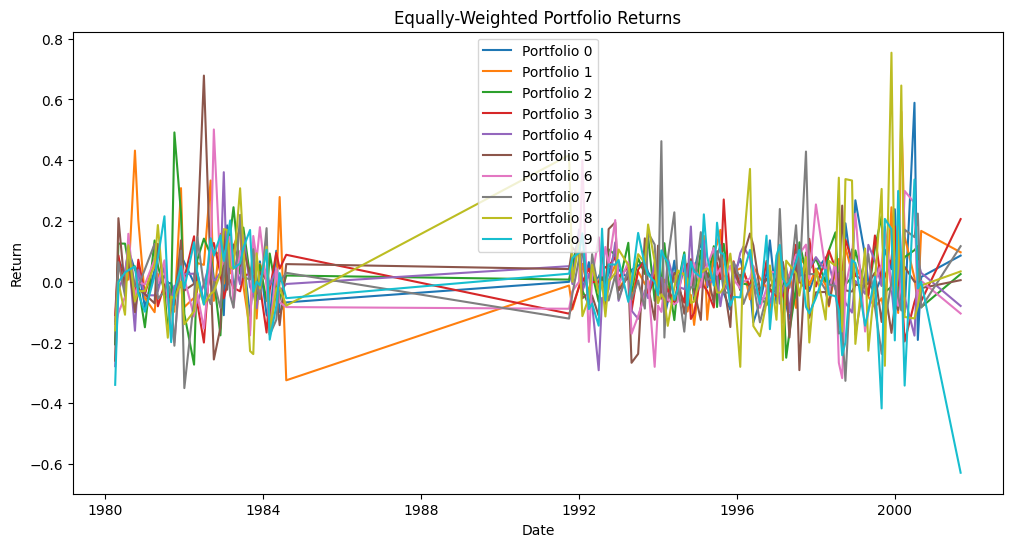

In [39]:
import matplotlib.pyplot as plt

# Plot equally-weighted portfolio returns
plt.figure(figsize=(12, 6))
for decile in range(10):
    plt.plot(monthly_portfolios_equal_weight['date'], monthly_portfolios_equal_weight[decile], label=f"Portfolio {decile}")
plt.title("Equally-Weighted Portfolio Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.show()


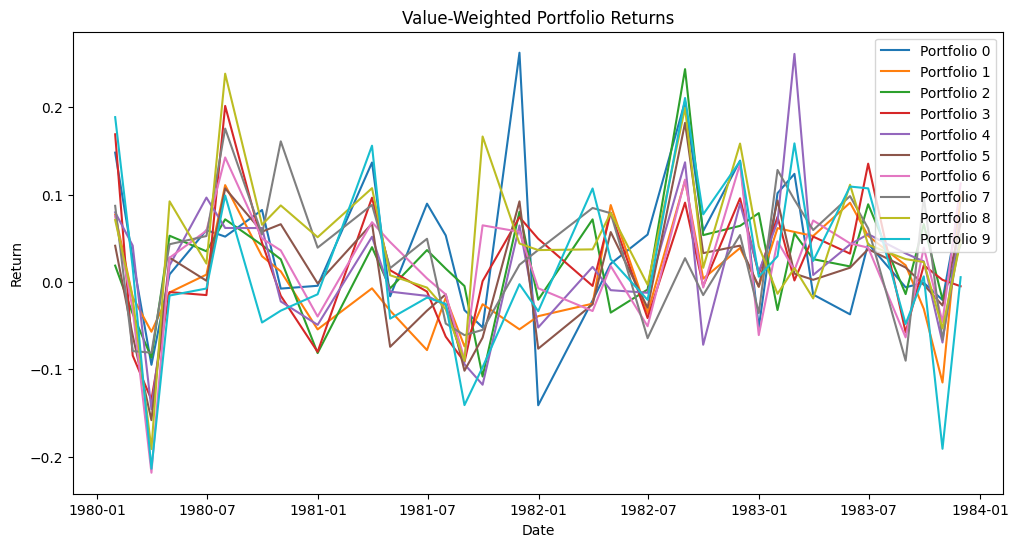

In [ ]:
# Plot value-weighted portfolio returns
plt.figure(figsize=(12, 6))
for decile in range(10):
    plt.plot(monthly_portfolios_value_weight['date'], monthly_portfolios_value_weight[decile], label=f"Portfolio {decile}")
plt.title("Value-Weighted Portfolio Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.show()

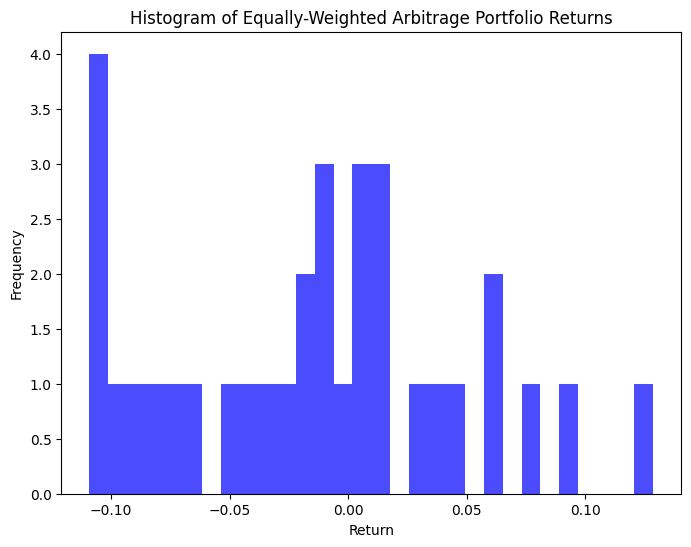

In [ ]:
# Histogram for equally-weighted arbitrage portfolio
plt.figure(figsize=(8, 6))
plt.hist(arbitrage_portfolio_equal_weight.dropna(), bins=30, color='blue', alpha=0.7)
plt.title("Histogram of Equally-Weighted Arbitrage Portfolio Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

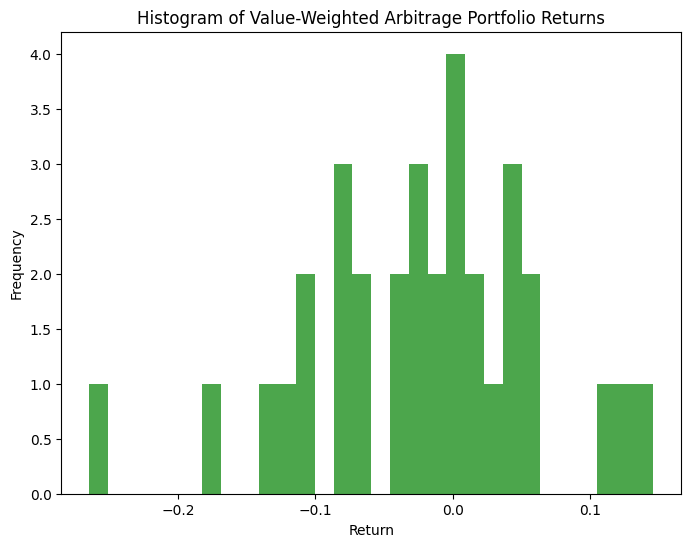

In [ ]:
# Histogram for value-weighted arbitrage portfolio
plt.figure(figsize=(8, 6))
plt.hist(arbitrage_portfolio_value_weight.dropna(), bins=30, color='green', alpha=0.7)
plt.title("Histogram of Value-Weighted Arbitrage Portfolio Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()